In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from collections import defaultdict

import numpy as np
import torch

import celltrip

np.random.seed(42)
torch.random.manual_seed(42)

In [ ]:
N = 4
M = 32
H = 200  # Number of cells
epochs = 10
batch_size = 64  # * H
max_updates = 200
device = 'cuda'

adatas = celltrip.utility.processing.read_adatas('../data/MERFISH/expression.h5ad', '../data/MERFISH/spatial.h5ad')
dataloader = celltrip.utility.processing.PreprocessFromAnnData(*adatas, num_nodes=H)
envs = [celltrip.environment.EnvironmentBase(dataloader, dim=3, target_modalities=1).to(device) for _ in range(N)]
policy = celltrip.policy.EntitySelfAttentionLite(6, dataloader.modal_dims[:1], 3).to(device)
celltrip.policy.orthogonal_init(policy)
# policy = celltrip.policy.Dummy(6, dataloader.modal_dims[:1], 3).to(device)
optimizer = torch.optim.Adam(policy.parameters(), weight_decay=1e-3, lr=3e-4)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=max_updates)

/home/thema/repos/inept/celltrip/utility/processing.py:108: RuntimeWarning: Modality 0 too small for PCA (253 features), skipping
  warnings.warn(
/home/thema/repos/inept/celltrip/utility/processing.py:108: RuntimeWarning: Modality 1 too small for PCA (2 features), skipping
  warnings.warn(


In [4]:
for _ in range(max_updates):
    # Perform M steps across all environments
    buffer = defaultdict(lambda: [])
    with torch.no_grad():
        for _ in range(M):
            # Step envs
            states = torch.stack([env.get_state(include_modalities=True) for env in envs], dim=0)  # Need to handle diff size envs
            _, actions, action_logs, state_vals = policy(states, sample=True, critic=True)
            ret = [env.step(act, return_itemized_rewards=True) for act, env in zip(actions, envs)]
            rewards, dones = torch.stack([r for r, _, _ in ret], dim=0), torch.tensor([d for _, d, _ in ret], dtype=torch.float, device=device)
            [env.reset() for env, (_, d, _) in zip(envs, ret) if d]  # Optional, reset envs
            buffer['states'].append(states)
            buffer['actions'].append(actions)
            buffer['action_logs'].append(action_logs)
            buffer['state_vals'].append(state_vals)
            buffer['rewards'].append(rewards)
            buffer['dones'].append(dones)
    for k in buffer: buffer[k] = torch.stack(buffer[k], dim=0)
    print(f'{buffer["rewards"].mean().cpu().item():.3f}', end='')

    # Perform GAE
    states = torch.stack([env.get_state(include_modalities=True) for env in envs], dim=0)
    next_advantages = 0
    with torch.no_grad(): next_state_vals, = policy(states, actor=False, critic=True)
    buffer['advantages'] = torch.zeros((M, N, H), device=device)
    gamma = .99; gae_lam = .95
    for i in range(M-1, -1, -1):
        deltas = buffer['rewards'][i] + gamma * next_state_vals * (1-buffer['dones'][i].unsqueeze(-1)) - buffer['state_vals'][i]
        buffer['advantages'][i] = next_advantages = deltas + gamma * gae_lam * next_advantages * (1-buffer['dones'][i].unsqueeze(-1))
        next_state_vals = buffer['state_vals'][i]

    # Update model
    for _ in range(epochs):
        # Shuffle data
        shuffle_idx = np.arange(N*M)
        np.random.shuffle(shuffle_idx)
        print('.', end='')

        # Batches
        for start_idx in range(0, N*M, batch_size):
            batch_idx = shuffle_idx[start_idx:start_idx+batch_size]
            batch_M = np.floor(batch_idx / N).astype(int)
            batch_N = np.mod(batch_idx, N)

            # Get advantages
            advantages = buffer['advantages'][batch_M, batch_N]
            advantages_mean, advantages_std = advantages.mean(), advantages.std() + 1e-8
            normalized_advantages = (advantages - advantages_mean) / advantages_std
            returns = advantages + buffer['state_vals'][batch_M, batch_N]
            # Get others
            _, action_logs, dist_entropy, state_vals = policy(
                buffer['states'][batch_M, batch_N], sample=True, action=buffer['actions'][batch_M, batch_N], entropy=True, critic=True)
            
            # PPO loss
            ratios = torch.exp(action_logs - buffer['action_logs'][batch_M, batch_N])
            unclipped_ppo = ratios * normalized_advantages
            clipped_ppo = torch.clamp(ratios, 1-.2, 1+.2) * normalized_advantages
            loss_ppo = -torch.min(unclipped_ppo, clipped_ppo)
            # Critic loss
            loss_critic = torch.nn.functional.smooth_l1_loss(state_vals, returns)  # TODO: Normalize
            # Entropy loss
            loss_entropy = -dist_entropy
            # Total loss
            loss = loss_ppo + .5*loss_critic + 1e-3*loss_entropy
            loss = loss.mean()

            # Step
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    # Step
    scheduler.step()


-4.121..........-2.767..........-2.871..........-1.713..........-1.119..........-0.815..........-0.485..........-0.334..........-0.235..........-0.312..........-1.122..........-0.515..........-1.024..........-1.136..........-4.214..........-11.814..........-8.273..........-30.039..........-56.375..........-300.941..........-92.687..........-242.083..........-48.246..........-1213.016..........-52.239..........-495.814..........

KeyboardInterrupt: 

/tmp/ipykernel_834780/2603536083.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


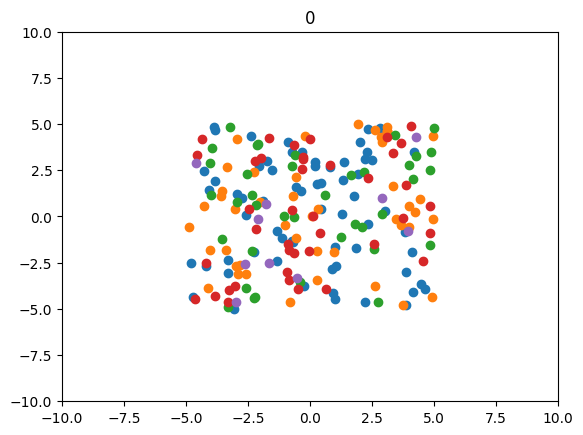

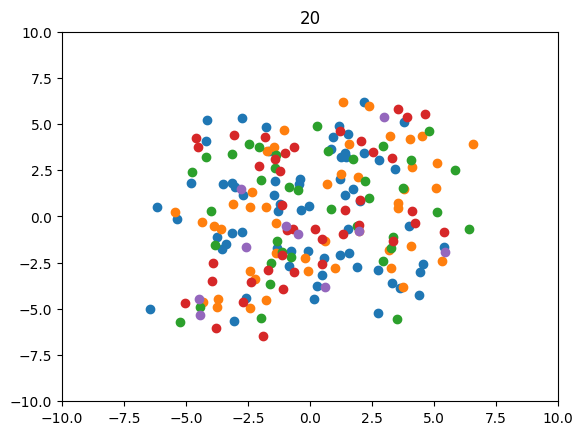

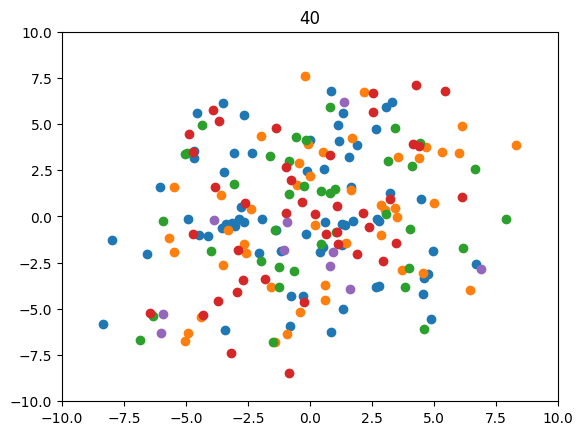

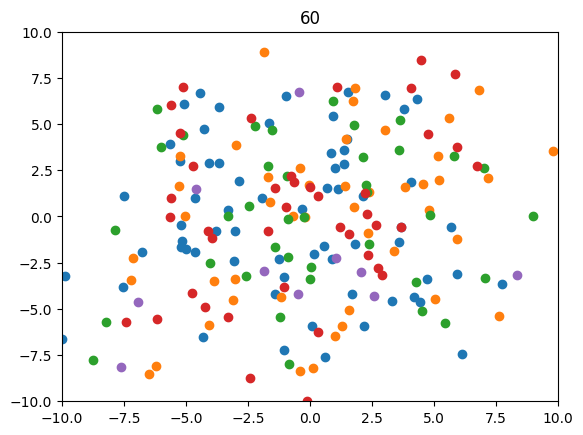

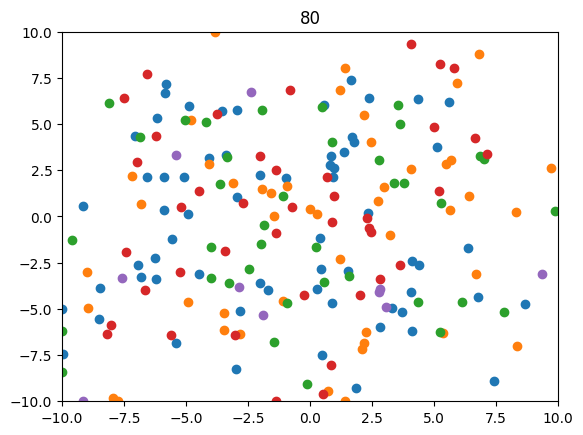

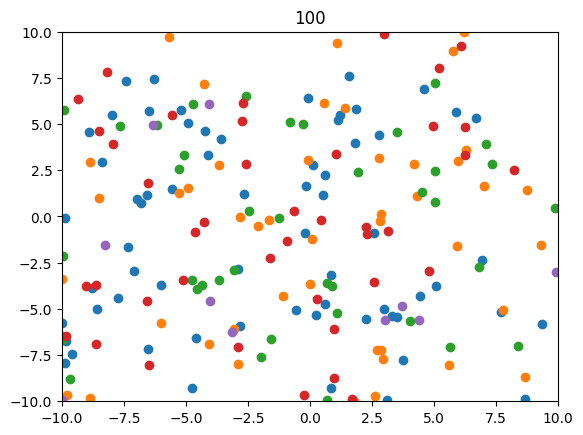

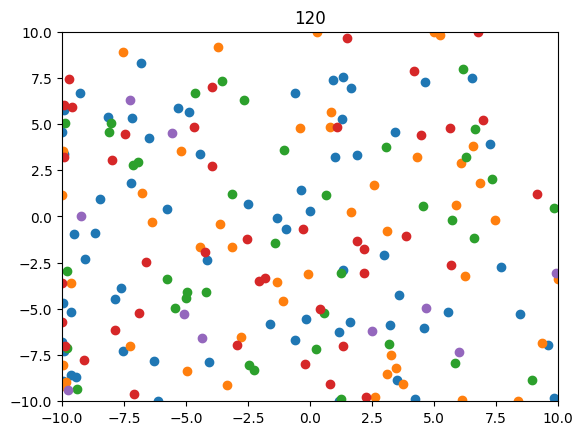

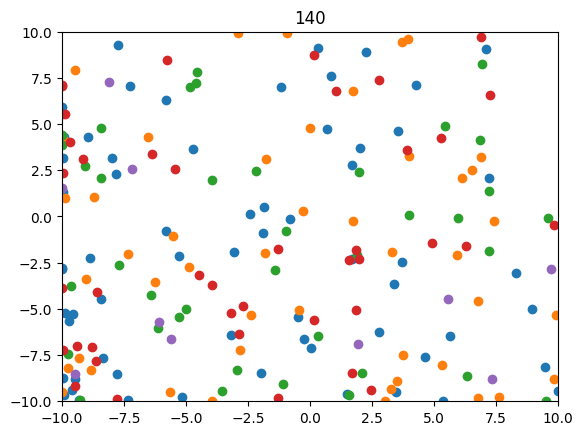

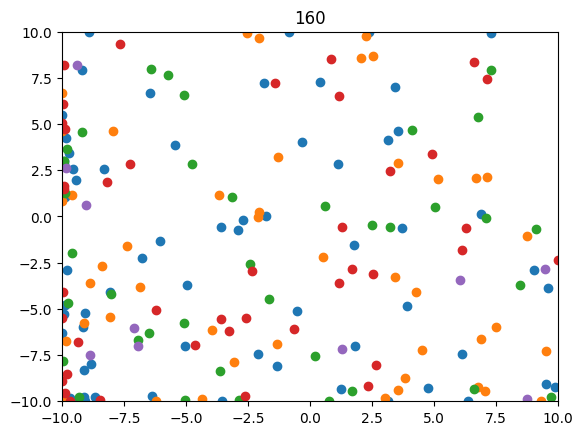

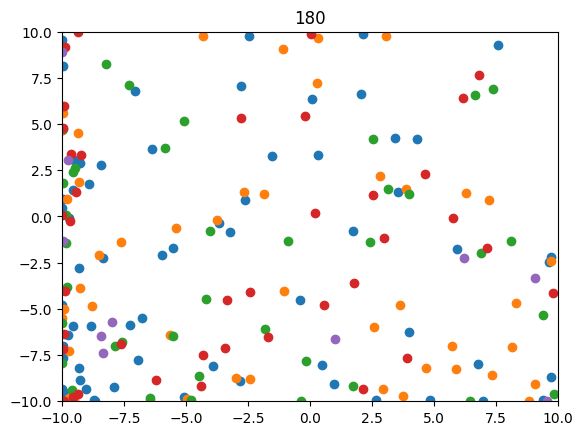

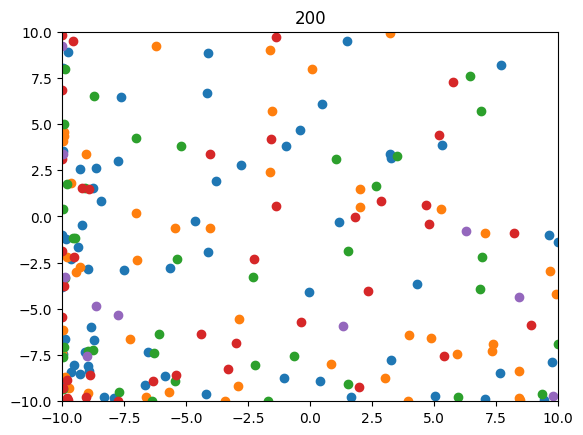

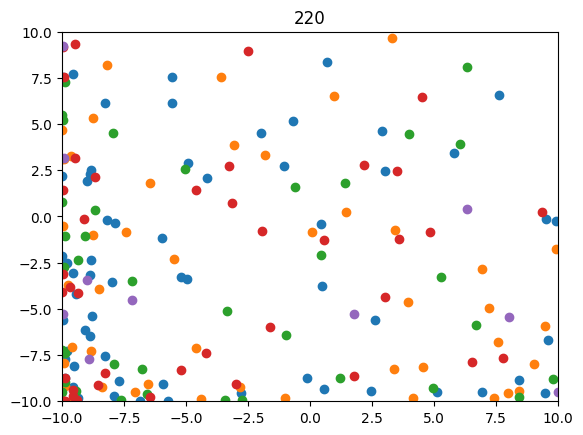

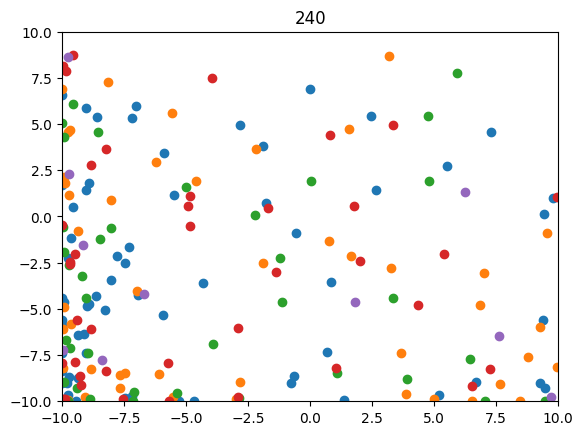

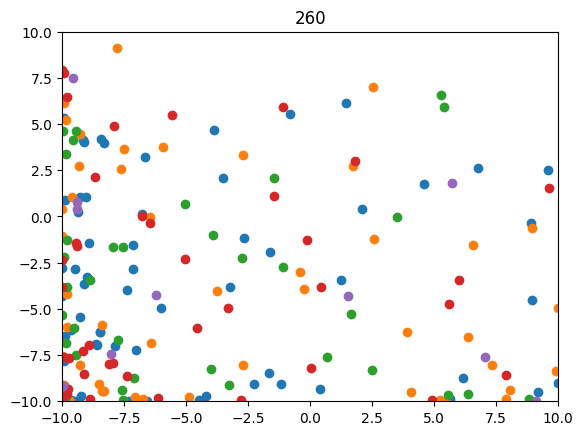

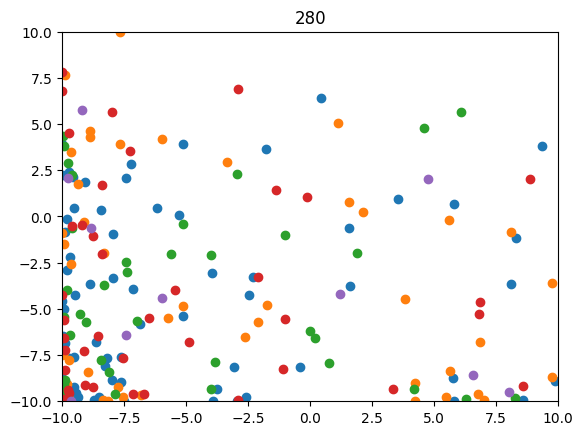

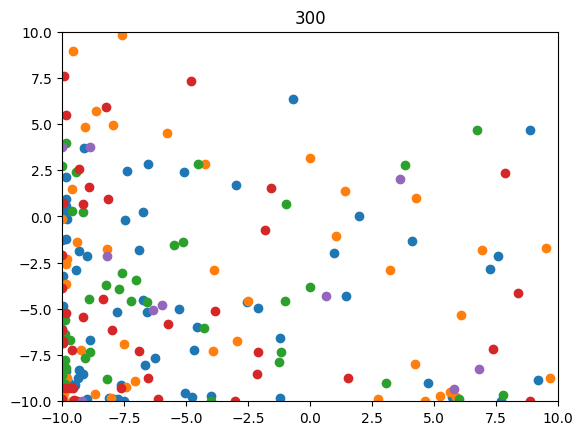

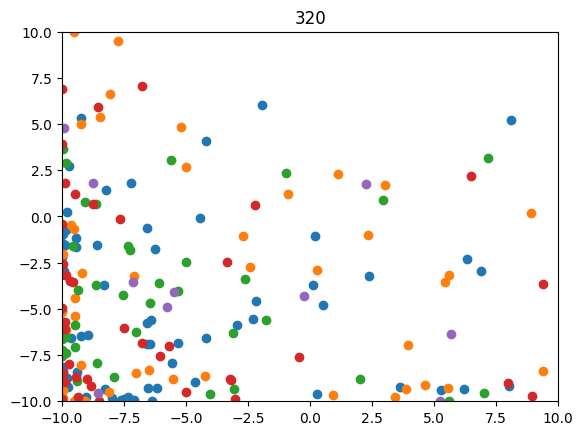

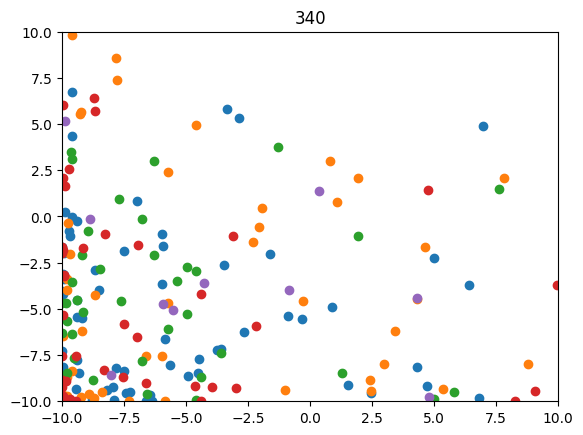

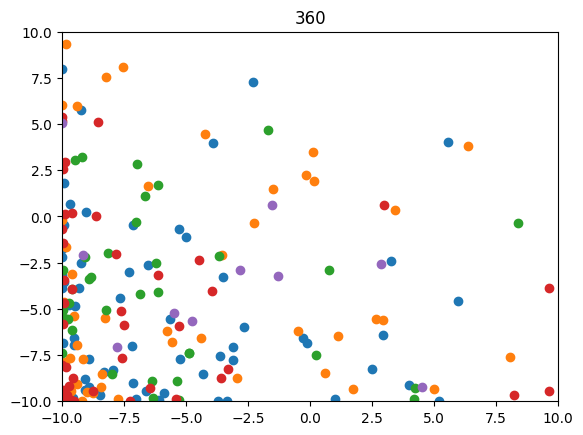

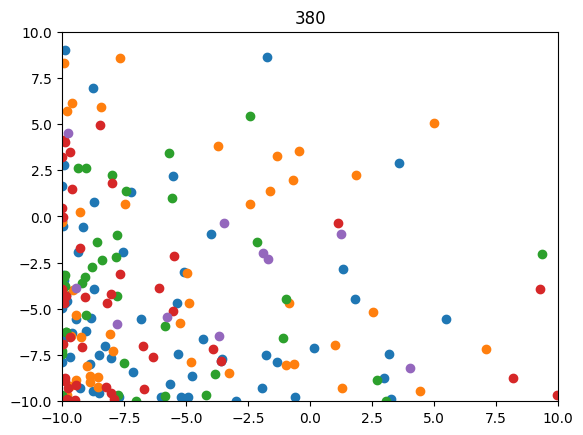

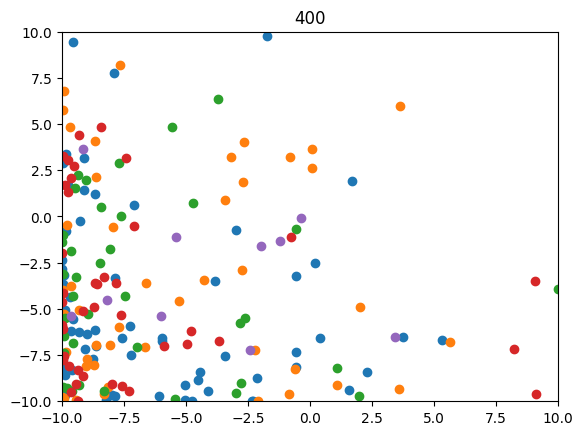

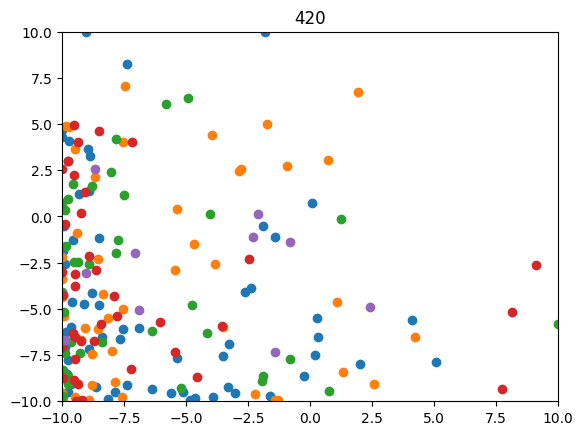

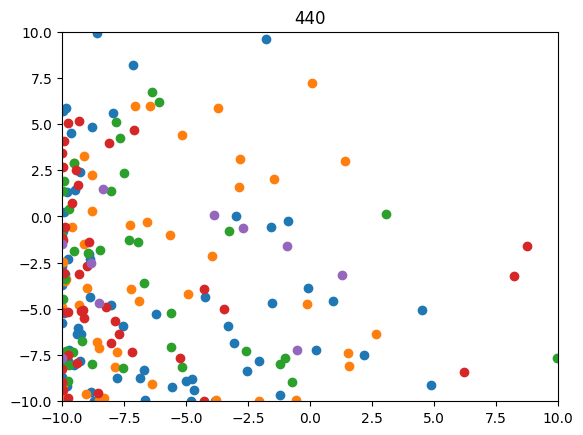

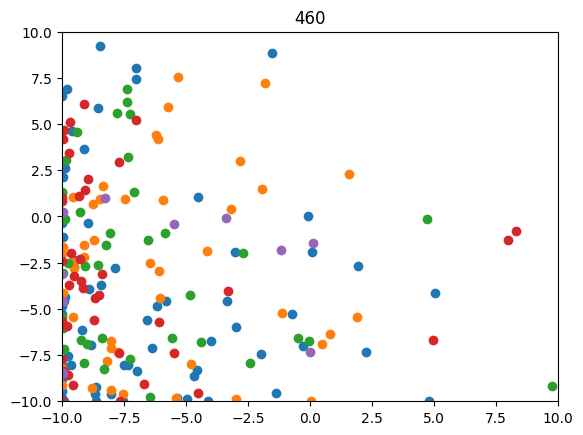

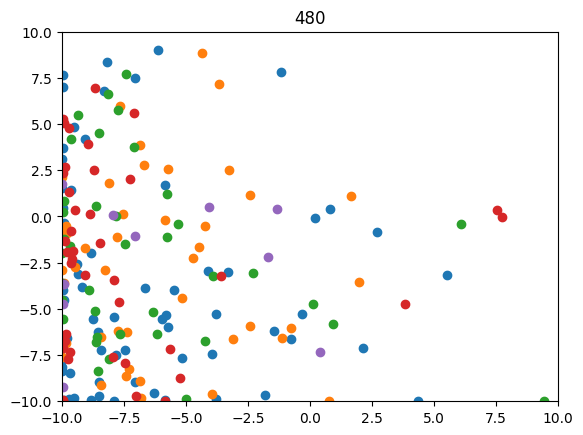

In [ ]:
# Preview agent
env = envs[0]
env.reset()

# Plot select states
import matplotlib.pyplot as plt
def plot_state(state):
    fig, ax = plt.subplots(1, 1)
    layers = env.dataloader.adatas[0].obs.loc[env.keys]['layer']
    for l in np.unique(layers):
        ax.scatter(*state[(layers==l).to_numpy(), :2].T, label=l)
    ax.set(xlim=(-10, 10), ylim=(-10, 10))
    fig.show()
    return ax
frame_skip = 20
while not env.finished():
    state = env.get_state(include_modalities=True)
    if env.timestep % frame_skip == 0:
        ax = plot_state(state.cpu())
        ax.set_title(f'{env.timestep}')
    _, actions, _ = policy(state, sample=True)
    env.step(actions)